# Analyzing the aggreement of charge state information

In [1]:
from util.containers import *

import os
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Intro:

Within phosphopedia, we have chosen to supply charge state info mostly from a spectral count standpoint. These aggregate values should give us information on the expected charge distributions of peptides, but we would like to have a handle on any bias the dataset presents. Thus, we ran Dinosaur on most of the files that we ran our detection pipeline on, hoping to extract information about charge affinity from the MS1 features. Here, we will look at that data and then match it to the info in the phosphopedia database. 

## Data Loading

PSM data is loaded straight from the build database

In [2]:
%%time
build = DatabaseBuild("data/builds/human_phospho/update_20210902/phosphopedia.db")

Loading PSMs...
Loading Peptides...
Loading Phosphosites
CPU times: user 3min 21s, sys: 24.4 s, total: 3min 45s
Wall time: 11min 13s


I would like to widdle the quantification data down to only have a single set of quantifications per peptide per file. To do this, I will use two criteria, number of mapped quantifications and number proximity to rtApex.

In [3]:
quant_data = pd.read_csv("data/processed/human_phospho/update_20210902/quant.csv")

In [4]:
quant_data["mzError"] = (quant_data.trueMZ - quant_data.mz).abs()
quant_data.sort_values("mzError", inplace=True)
quant_data = quant_data.drop_duplicates(["idPeptide", "idPSM", "charge"])
#quant_data = quant_data.groupby(["idPeptide", "idPSM", "charge"]).first().reset_index()

In [5]:
match_count = quant_data.groupby(["idPeptide", "sampleName", "idPSM"]).charge.count().rename("quantCount")

In [6]:
detection_distance = quant_data.groupby(["idPeptide", "sampleName", "idPSM"])[["detectionRT", "rtApex"]].first()
detection_distance["rtDistance"] = (detection_distance.detectionRT - detection_distance.rtApex).abs()

In [7]:
allowed_psms = match_count.to_frame().join(detection_distance)[["quantCount", "rtDistance"]]\
                                     .sort_values("quantCount", ascending=False)\
                                     .sort_values("rtDistance")\
                                     .reset_index()\
                                     .groupby(["idPeptide", "sampleName"])\
                                     .first()\
                                     .reset_index()[["idPeptide", "sampleName", "idPSM"]]

In [8]:
filtered_quant = allowed_psms.join(quant_data.set_index(["idPeptide", "sampleName", "idPSM"]),
                                   on=["idPeptide", "sampleName", "idPSM"])\
                             .loc[:, ["idPSM", "idPeptide", "sampleName", 
                                      "charge", "intensityApex", "intensitySum"]]\
                             .join(build.peptides.set_index("id").sequence,
                                   how="right", 
                                   on = "idPeptide")

## Analysis of quantification success

The first analysis is looking at how many detections per sample can be mapped to at least one quantification. This can be analyzed simply by looking at the total number of peptides in each sample in the PSM data vs the quant data.

In [9]:
peptides_per_sample = build.psms.groupby(["sample_name", "pep_id"])\
                                .count()\
                                .reset_index()\
                                .groupby("sample_name")\
                                .id\
                                .count()\
                                .rename("detection_count")\
                                .reset_index()
quants_per_sample = filtered_quant.groupby(["sampleName", "idPeptide"])\
                                  .count()\
                                  .reset_index()\
                                  .groupby("sampleName")\
                                  .idPSM\
                                  .count()\
                                  .rename("quant_count")

joined_per_sample = peptides_per_sample.join(quants_per_sample, on="sample_name", how="left")

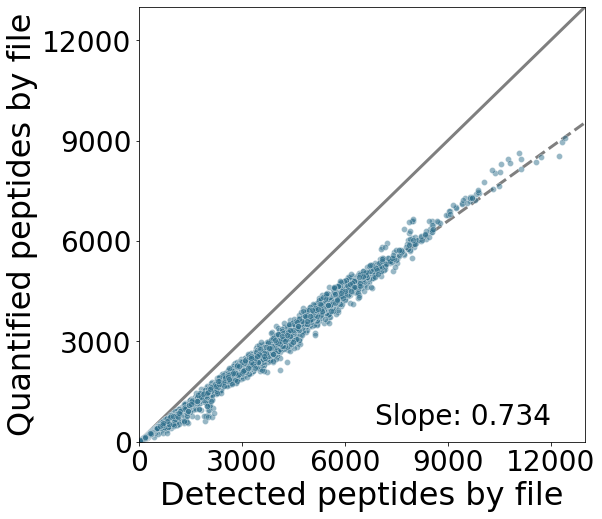

In [10]:
plt.figure(figsize=[8, 8])

plt.plot(*[[-100, 15000]]*2,
         c="black",
         lw=3,
         alpha=.5,
         zorder=-1)

slope = np.mean(joined_per_sample.quant_count/joined_per_sample.detection_count)
plt.plot([-100, 15000],
         [-100, slope*15000],
         c="black",
         linestyle="--",
         lw=3,
         alpha=.5,
         zorder=-1)
plt.text(x=12000, y=500, ha="right", size=28,
         s="Slope: {:.3f}".format(slope))


sns.scatterplot(data=joined_per_sample,
                x="detection_count", 
                y="quant_count", 
                alpha=.5,
                linewidth=.5,
                color="#30708d")

plt.xlabel("Detected peptides by file", size=32)
plt.ylabel("Quantified peptides by file", size=32)
plt.tick_params(labelsize=28)
plt.xlim(0, 13000)
plt.xticks([0, 3000, 6000, 9000, 12000])
plt.ylim(0, 13000)
plt.yticks([0, 3000, 6000, 9000, 12000])

plt.savefig("figures/file_detections_vs_quantifications.svg")
plt.show()

From previous analyses done by me and lab members, this does seem a bit low. However, it is difficult to tell right now why we wouldn't obtain as many quants to matches as say an unmodified dataset would find.

Next I will look to see if there are any problematic peptides. Peptides which just do not match well to quants accross the dataset. This can easily be done by just comparing the amount of files that a peptide was detected in to the amount of files a peptide was quantified in.

In [11]:
files_with_detection_per_peptide = build.psms.groupby(["sample_name", "pep_id"])\
                                             .count()\
                                             .reset_index()\
                                             .groupby("pep_id")\
                                             .id\
                                             .count()\
                                             .rename("files_with_detection_count")\
                                             .reset_index()
files_with_quant_per_peptide = filtered_quant.groupby(["sampleName", "idPeptide"])\
                                             .count()\
                                             .reset_index()\
                                             .groupby("idPeptide")\
                                             .idPSM\
                                             .count()\
                                             .rename("files_with_quant_count")

joined_per_peptide = files_with_detection_per_peptide.join(files_with_quant_per_peptide, 
                                                           on="pep_id", 
                                                           how="left").fillna(0.)

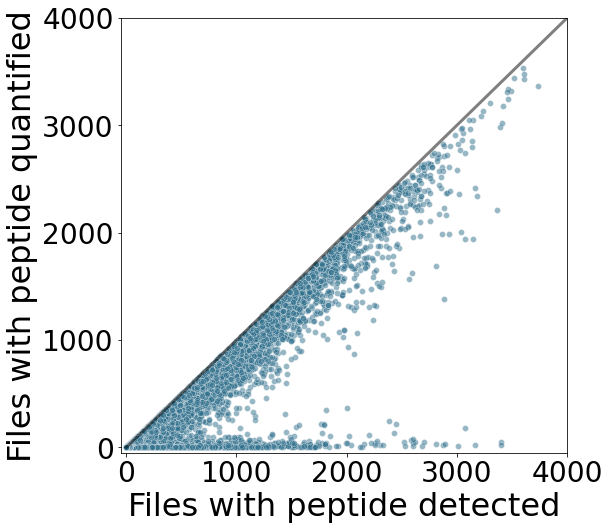

In [47]:
fig = plt.figure(figsize=[8, 8])

plt.plot(*[[0, 4000]]*2,
         c="black",
         lw=3,
         alpha=.5)
sns.scatterplot(data=joined_per_peptide,
                x="files_with_detection_count", 
                y="files_with_quant_count", 
                alpha=.5,
                linewidth=.5,
                color="#30708d")

#slope = .2
#plt.plot([0, 4000],
#         [0, slope*4000])

plt.xlabel("Files with peptide detected", size=32)
plt.ylabel("Files with peptide quantified", size=32)
plt.tick_params(labelsize=28)
plt.xlim(-50, 4000)
plt.xticks([0, 1000, 2000, 3000, 4000])
plt.ylim(-50, 4000)
plt.yticks([0, 1000, 2000, 3000, 4000])

plt.savefig("figures/peptide_detections_vs_quantifications.svg")
plt.show()

It is obvious that there is a significant chunk of peptides that just do not quantify well. These should be extracted before any modeling can occur.

## Average number of quantified charge states

It is of interest to me to know how many charge states that peptides tend to be quantified in as compared to the amount they tend to be detected in. I presume the second number should be smaller.

In [13]:
max_charge_states = filtered_quant.groupby(["idPeptide", "sampleName"]).charge.count().reset_index()\
                                  .groupby(["idPeptide"]).charge.max()

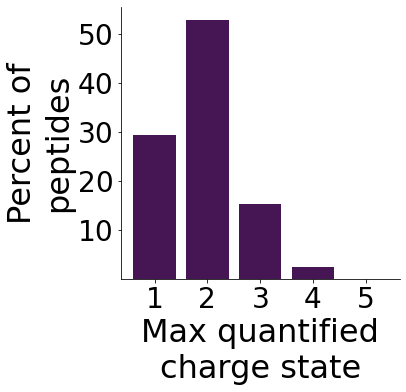

In [14]:
fig = plt.figure(figsize=[5, 5])

charge, count = np.unique(max_charge_states, return_counts=True)
plt.bar(charge, 100*count/sum(count), color="#461554")

plt.xlabel("Max quantified\ncharge state", size=32)
plt.ylabel("Percent of\npeptides", size=32)
plt.tick_params(labelsize=28)
plt.xticks([1, 2, 3, 4, 5])
plt.yticks([10, 20, 30, 40, 50])
fig.get_axes()[0].spines["right"].set_visible(False)
fig.get_axes()[0].spines["top"].set_visible(False)

plt.savefig("figures/quant_charge_state_distribution.svg")
plt.show()

What is interesting here is that this distribution is definitely pushed rightward from the detected charge states. This implies that most peptides have sufficient signal in at least 2 charge states, but they are definitely being selectively sampled by the DDA runs.

## Correspondence of quantification data and detections

In [15]:
total_detections = build.psms.groupby(["pep_id"])\
                             .id\
                             .count()\
                             .rename("total")\
                             .reset_index()\
                             .rename({"pep_id": "idPeptide"},
                                     axis=1)

In [16]:
max_detected_charge = build.psms.groupby(["pep_id", "precursor_charge"])\
                                .id\
                                .count()\
                                .sort_values(ascending=False)\
                                .rename("nDetections")\
                                .reset_index()\
                                .groupby("pep_id")\
                                .first()\
                                .reset_index()\
                                .rename({"pep_id" : "idPeptide",
                                         "precursor_charge" : "maxDetectedCharge"},
                                        axis=1)

In [17]:
max_quantified_charge = filtered_quant.sort_values("intensityApex", ascending=False)\
                                      .groupby(["idPeptide", "sampleName"])\
                                      .charge\
                                      .first()\
                                      .reset_index()\
                                      .groupby(["idPeptide", "charge"])\
                                      .idPeptide\
                                      .count()\
                                      .rename("nAsMax")\
                                      .reset_index()\
                                      .sort_values("nAsMax", ascending=False)\
                                      .groupby("idPeptide")\
                                      .first()\
                                      .reset_index()\
                                      .rename({"charge" : "maxQuantifiedCharge"},
                                               axis=1)

In [18]:
joined_maxes = max_detected_charge.join(max_quantified_charge.set_index("idPeptide"),
                                        on="idPeptide",
                                        how="inner")\
                                  .join(total_detections.set_index("idPeptide"),
                                        on="idPeptide")
joined_maxes["corresponds"] = joined_maxes.maxDetectedCharge == joined_maxes.maxQuantifiedCharge

In [19]:
correspondence = joined_maxes.groupby("maxDetectedCharge")\
                             .corresponds\
                             .sum()\
                             .reset_index()\
                             .join(joined_maxes.groupby("maxDetectedCharge")\
                                               .corresponds\
                                               .count()\
                                               .rename("total"),
                                   on="maxDetectedCharge")

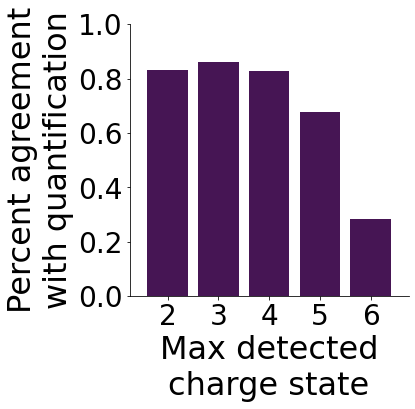

In [20]:
fig = plt.figure(figsize=[5, 5])

charge, count = np.unique(max_charge_states, return_counts=True)
plt.bar(correspondence.maxDetectedCharge,
        correspondence.corresponds/correspondence.total, 
        color="#461554")

plt.xlabel("Max detected\ncharge state", size=32)
plt.ylabel("Percent agreement\nwith quantification", size=32)
plt.tick_params(labelsize=28)
plt.xlim(1.25, 6.75)
plt.xticks([2, 3, 4, 5, 6])
plt.ylim(0, 1)
plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
fig.get_axes()[0].spines["right"].set_visible(False)
fig.get_axes()[0].spines["top"].set_visible(False)

plt.savefig("figures/detection_agreement_with_quantification.svg")
plt.show()

The above plot shows the agreement of the max charge state from MS1 signal to the max charge state from selection. For the most part the agreement looks quite good. The higher charge states don't tend to agree very well with the signal, which is a bit of a mystery. It could be a problem with the acquisition, or it may be that the higher charge states tend to be less interfered and thus more likely to be selected.

In [21]:
med_int_prop = filtered_quant.join(filtered_quant.groupby(["idPeptide", "sampleName"])\
                                                 .intensityApex\
                                                 .sum()\
                                                 .rename("intensityApexSum"),
                                                  on=["idPeptide", "sampleName"])
med_int_prop["intensityApexProportion"] =med_int_prop.intensityApex/med_int_prop.intensityApexSum

med_int_prop = med_int_prop.groupby(["idPeptide", "charge"]).intensityApexProportion.median()

In [22]:
prop_by_max_detected_charge = max_detected_charge.join(med_int_prop,
                                                       how="inner",
                                                       on=["idPeptide", "maxDetectedCharge"])

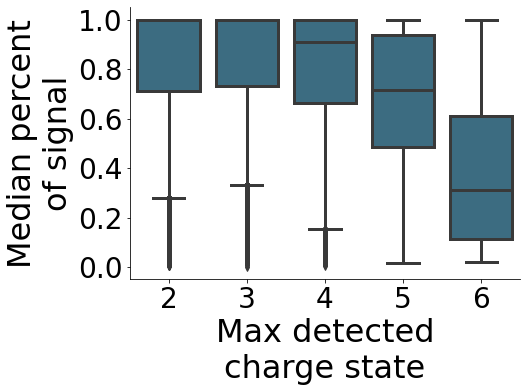

In [23]:
fig = plt.figure(figsize=[7, 5])

sns.boxplot(data=prop_by_max_detected_charge,
            x="maxDetectedCharge",
            y="intensityApexProportion",
            color="#30708d",
            linewidth=3)

plt.xlabel("Max detected\ncharge state", size=32)
plt.ylabel("Median percent\nof signal", size=32)
plt.tick_params(labelsize=28)
plt.xticks([0, 1, 2, 3, 4], [2, 3, 4, 5, 6])
plt.yticks([0, 0.2, 0.4, .6, .8, 1.])
fig.get_axes()[0].spines["right"].set_visible(False)
fig.get_axes()[0].spines["top"].set_visible(False)

plt.savefig("figures/percent_of_signal_from_max_charge.svg")
plt.show()

Again, this looks really good. Even though we can detect multiple features in the MS1 corresponding to a peptide. The max charge from a count perpective is usualy a feature with most of the signal. It is still interesting that the charge 6 peptides still tend to be so low, but this would require much more analysis to teaze out.

## Prepping data for future learning

Above, I talked about problematic peptides, or peptides which are well detected but not well quantified in the MS1. Here, I really just want to drop thos peptides so that I don't have to deal with them later. Further steps to reduce the data will be taken elsewhere, as the decisions may be variable.

In [48]:
select = joined_per_peptide.files_with_quant_count > 0.2 * joined_per_peptide.files_with_detection_count
passing_peptides = joined_per_peptide[select].join(filtered_quant[["idPeptide", "sequence"]]\
                                                                 .drop_duplicates()\
                                                                 .set_index("idPeptide"),
                                                   on="pep_id",
                                                   how="inner")\
                                             .sequence\
                                             .to_frame()

In [49]:
passing_quant = passing_peptides.join(filtered_quant.set_index("sequence"),
                                      on="sequence").loc[:, ["idPSM", "idPeptide", "sequence",
                                                             "sampleName", "charge", 
                                                             "intensityApex", "intensitySum"]]
passing_quant["idPSM"] = passing_quant["idPSM"].astype(int)
passing_quant["charge"] = passing_quant["charge"].astype(int)

In [50]:
passing_quant.to_csv("data/processed/human_phospho/update_20210902/filtered_quant.csv")